In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [3]:
# load data

train_set = datasets.MNIST(root='data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor()
                             )

test_set = datasets.MNIST(root='data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor()
                            )

# make a validation set

train_length = len(train_set)
train_size = int(train_length * 0.85)
val_size = train_length - train_size

train_set, val_set = torch.utils.data.random_split(train_set, [train_size, val_size])

# store train and val loss
train_loss_list = []
val_loss_list = []
epoch_list = []
train_acc_list = []
val_acc_list = []


C:\Users\lewiis\anaconda3\envs\deep_learning\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


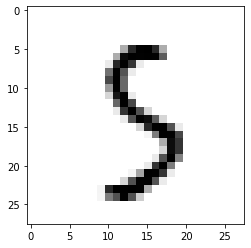

In [4]:
plt.figure(1)
img, label = train_set[7]
plt.imshow(img.squeeze(), cmap='binary')

In [5]:
img.size()

torch.Size([1, 28, 28])

In [6]:
# network architecture

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=48, kernel_size=3,
                      padding=1),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(64*7*7,128),
            nn.ReLU(),
            nn.Linear(128, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 64*7*7)
        out = self.layer3(out)
        return out


In [7]:
# training loop

def train_loop(epochs, optimizer, model, loss_fn, train_loader, val_loader):

    for epoch in range(1, epochs+1):
        loss_train = 0.0
        correct = 0
        total = 0

        for imgs, labels in train_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            total += labels.shape[0]
            correct += int((predicted==labels).sum())

            train_correct = correct
            train_total = total

        epoch_list.append(epoch)
        train_loss_list.append(loss_train)

        # test on validation data
        # get loss of validation data
        with torch.no_grad():
            loss_val = 0.0
            correct = 0
            total = 0
            for imgs, labels in val_loader:
                # move tensors to gpu if available
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)

                outputs = model(imgs)

                loss_v = loss_fn(outputs, labels)

                loss_val += loss_v.item()

                _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())
            val_correct = correct
            val_total = total


        val_loss_list.append(loss_val / len(val_loader))

        train_acc_list.append(train_correct/train_total)
        val_acc_list.append(val_correct/val_total)

        # set when to print info about training progress
        if epoch == 1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {:.3f}, Validation loss {:.3f}, Train Acc {:.3f}, Val Acc {:.3f}'.format(epoch, loss_train / len(train_loader), loss_val / len(val_loader), train_correct/train_total, val_correct/val_total),
                  )

def test_loop(model, test_loader):
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in test_loader:

            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
            total += labels.shape[0]  # Counts the number of examples, so total is increased by the batch size
            correct += int((predicted == labels).sum())


    print("Accuracy test: {:.3f} %".format(100 *  (correct / total)))

In [9]:
epochs = 1
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
# epoch_num_of_no_improve = 5

train_loop(
    epochs = epochs,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
    val_loader = val_loader)

test_loop(model, test_loader)

Epoch 1, Training loss 1.584, Validation loss 1.489, Train Acc 0.879, Val Acc 1.000
Accuracy test: 97.610 %


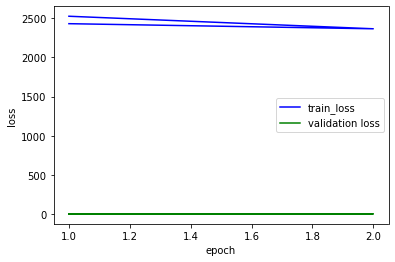

In [10]:
plt.figure(2)
plt.plot(epoch_list, train_loss_list, color='blue', label='train_loss')
plt.plot(epoch_list, val_loss_list, color='green', label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

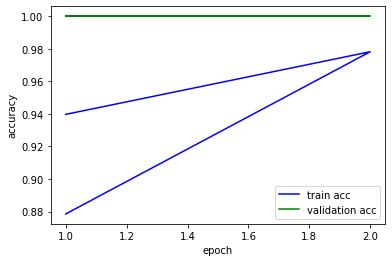

In [11]:
plt.figure(3)
plt.plot(epoch_list, train_acc_list, color='blue', label='train acc')
plt.plot(epoch_list, val_acc_list, color='green', label='validation acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

Text(230.20000000000005, 0.5, 'predicted label')

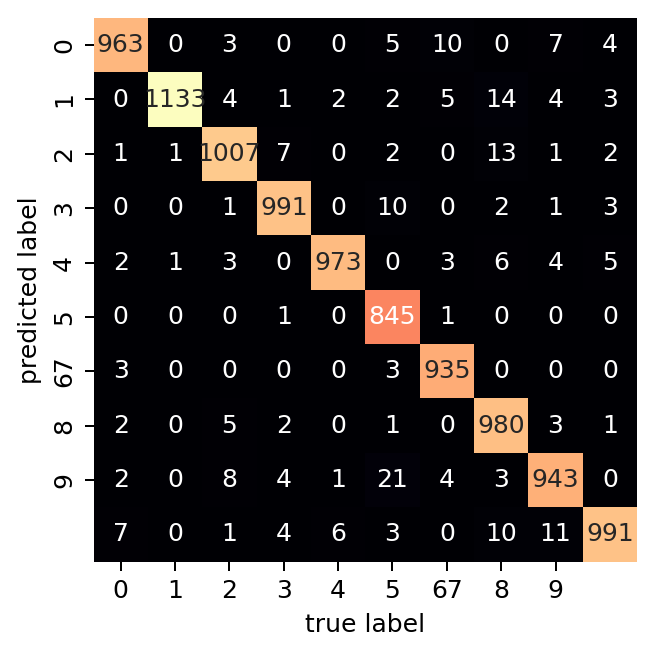

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
y_fit = np.array([])
y_test = np.array([])

for imgs, labels in test_loader:
    model = model.to('cpu')

    outputs = model(imgs)

    _, predicted = torch.max(outputs, dim=1) # Gives us the index of the highest value
    predicted = predicted.detach().numpy()
    labels = labels.detach().numpy()
    y_fit = np.concatenate((y_fit, predicted), axis=None)
    y_test = np.concatenate((y_test, labels), axis=None)
    # y_fit.append(predicted)
    # y_test.append(labels)

labels_names = ['0', '1', '2', '3', '4', '5', '6' '7', '8', '9']

plt.figure(6, dpi=180)
conf_matrix = confusion_matrix(y_test, y_fit)
conf_matrix = pd.DataFrame(conf_matrix)
sns.heatmap(conf_matrix.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=labels_names, yticklabels=labels_names, cmap='magma')
plt.xlabel('true label')
plt.ylabel('predicted label')